# NLP FINAL Project

### Importing Packages

In [22]:
import numpy as np 
import pandas as pd
import string 
import nltk
import re
from bs4 import BeautifulSoup
import requests
from string import punctuation
stopword = nltk.corpus.stopwords.words('english')
from matplotlib.pyplot import subplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import bar
import itertools

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

wn = nltk.WordNetLemmatizer()
le = preprocessing.LabelEncoder()
C_vec = CountVectorizer()

### Extracting Lyrics from Data

In [ ]:
url = data.iloc[:,2]
lyric_list = []
for URL in url:
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string

    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    lyric_list.append(lyrics)
%store lyric_list

In [23]:
%store -r lyric_list
print(len(lyric_list))

2022


# BASELINE APPROACH

# PROJECT CODE

### Importing File

In [24]:
data = pd.read_csv('final_song_data.csv',delimiter=',',header =None)
artist_name = data.iloc[:,0]
song_name = data.iloc[:,1]
data_set = [list(data_row) for data_row in zip(artist_name,song_name,lyric_list)]
labels = le.fit_transform(data.iloc[:,3])
n_classes=len(data.iloc[:,3].unique())

### Pre-Processing Function for Train and Test

In [25]:
def process_features(data_set):
    
    lyric_list_new = []
    artist_name_new = []
    song_name_new = []
    chorus_list = []
    verse_list = []
    bridge_list = []
    hook_list = []
    intro_list = []
    outro_list = []
    song_length = []
    for dat in data_set:
        s = dat[2]
        chorus_list.append(len(re.findall('\[Chorus', s)))
        verse_list.append(len(re.findall('\[Verse', s)))
        hook_list.append(len(re.findall('\[Hook', s)))
        bridge_list.append(len(re.findall('\[Bridge', s)))
        intro_list.append(len(re.findall('\[Intro', s)))
        outro_list.append(len(re.findall('\[Outro', s)))

        v = s.split("\n")
        song_length.append(len(v))
        for i in v:
            d = re.sub("^\[(.*)]","",i)
            v[v.index(i)] = d
        lyric_list_new.append("\n".join(v))       
        
        artist_name_new.append(dat[0])
        song_name_new.append(dat[1])

   
    for element in range(1,len(lyric_list_new)): 
        
        #LYRICS
        lyric_list_new[element] =lyric_list_new[element].replace("'"," ")
        lyric_list_new[element] = re.sub(r'[^\w\s]','',lyric_list_new[element])
        lyric_list_new[element] = nltk.word_tokenize(lyric_list_new[element])
        not_stopword_list = [word.lower() for word in lyric_list_new[element] if word.lower() not in stopword]
        t = " ".join([wn.lemmatize(word) for word in not_stopword_list])
        lyric_list_new[element]=t
        
        #ARTIST
        artist_name_new[element] =artist_name_new[element].replace(",","")
        artist_name_new[element] =artist_name_new[element].replace("&","")

        
        #SONG TITLE
        song_name_new[element] =song_name_new[element].replace("'"," ")
        song_name_new[element] = re.sub(r'[^\w\s]','',song_name_new[element])
        song_name_new[element] = nltk.word_tokenize(song_name_new[element])
        not_stopword_list = [word.lower() for word in song_name_new[element] if word.lower() not in stopword]
        t = " ".join([wn.lemmatize(word) for word in not_stopword_list])
        song_name_new[element]=t
        
    data_set_new = [artist_name_new,song_name_new,lyric_list_new]
    lyric_all = np.vstack((np.array(chorus_list),np.array(verse_list),np.array(bridge_list),np.array(hook_list),np.array(intro_list),np.array(outro_list),np.array(song_length)))
    lyric_all = np.transpose(lyric_all)
    return data_set_new,lyric_all

### Train-Test split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data_set,labels, train_size=0.8,test_size = 0.2)

#Training Set 
dataset_train_sub,feat_add_train = process_features(x_train)
artist_train_sub = dataset_train_sub[0]
song_title_train_sub = dataset_train_sub[1]
lyric_train_sub = dataset_train_sub[2]
lyric_train_label = y_train


#Test set 
dataset_test_sub,feat_add_test = process_features(x_test)
artist_test_sub = dataset_test_sub[0]
song_title_test_sub = dataset_test_sub[1]
lyric_test_sub = dataset_test_sub[2]
lyric_test_label = y_test

### Feature Extraction
##### Bag Of Words Approach

In [27]:
#FEATURE EXTRACTION
C_vec = CountVectorizer(max_df = 0.5,min_df = 2,ngram_range = (1,2))
trainX1 = C_vec.fit_transform(lyric_train_sub).toarray()
testX1 = C_vec.transform(lyric_test_sub).toarray()
# print(C_vec.get_feature_names())

C_vec = CountVectorizer(ngram_range = (1,3))
trainX2 = C_vec.fit_transform(artist_train_sub).toarray()
testX2 = C_vec.transform(artist_test_sub).toarray()
print(C_vec.get_feature_names())

C_vec = CountVectorizer(max_df = 0.5,min_df = 2,ngram_range = (1,2))
trainX3 = C_vec.fit_transform(song_title_train_sub).toarray()
testX3 = C_vec.transform(song_title_test_sub).toarray()
print(C_vec.get_feature_names())

lyric_train = np.hstack((trainX1,trainX2,trainX3,feat_add_train))
lyric_test = np.hstack((testX1,testX2,testX3,feat_add_test))


#Final feature : lyric_train
print("Train Data Shape: ",np.shape(lyric_train))
print("Test Data Shape: ",np.shape(lyric_test))


['182', '1910', '1910 fruitgum', '1910 fruitgum company', '1975', '21', '21 savage', '21 savage and', '21 savage offset', '2pac', '50', '50 cent', '52s', '6ix9ine', '6lack', 'ab', 'ab soul', 'abstract', 'accept', 'action', 'action bronson', 'adele', 'after', 'after sex', 'again', 'against', 'against the', 'against the machine', 'aiko', 'ajr', 'alan', 'alan walker', 'alessia', 'alessia cara', 'allred', 'aloe', 'aloe blacc', 'alpert', 'alt', 'am', 'amine', 'amsterdam', 'amy', 'amy winehouse', 'and', 'and anne', 'and anne marie', 'and balvin', 'and beyonce', 'and camila', 'and camila cabello', 'and cardi', 'and coldplay', 'and crazy', 'and crazy horse', 'and damian', 'and damian marley', 'and david', 'and david guetta', 'and drake', 'and dua', 'and dua lipa', 'and emily', 'and emily warren', 'and eminem', 'and fire', 'and future', 'and garfunkel', 'and grey', 'and guy', 'and guy sebastian', 'and halsey', 'and james', 'and james blake', 'and kanye', 'and kanye west', 'and kehlani', 'and ke

Train Data Shape:  (1617, 43950)
Test Data Shape:  (405, 43950)


#### Tfidf Approach

In [7]:
#FEATURE EXTRACTION
T_vec = TfidfVectorizer(max_df = 0.5,min_df = 1,ngram_range = (1,2))
trainX1_tf = T_vec.fit_transform(lyric_train_sub).toarray()
testX1_tf = T_vec.transform(lyric_test_sub).toarray()

T_vec = TfidfVectorizer(ngram_range = (1,2))
trainX2_tf = T_vec.fit_transform(artist_train_sub).toarray()
testX2_tf = T_vec.transform(artist_test_sub).toarray()


T_vec = TfidfVectorizer(max_df = 0.5,min_df = 1,ngram_range = (1,2))
trainX3_tf = T_vec.fit_transform(song_title_train_sub).toarray()
testX3_tf = T_vec.transform(song_title_test_sub).toarray()

lyric_train = np.hstack((trainX1_tf,trainX2_tf,trainX3_tf,feat_add_train))
lyric_test = np.hstack((testX1_tf,testX2_tf,testX3_tf,feat_add_test))


#Final feature : lyric_train
print("Train Data Shape: ",np.shape(lyric_train))
print("Test Data Shape: ",np.shape(lyric_test))


Train Data Shape:  (1617, 24704)
Test Data Shape:  (405, 24704)


# CLASSIFIERS

### Multinomial Naive Bayes

In [28]:
n_class1=0
n_class2=0
n_class3=0

for i in lyric_train_label:
    if(i==0):
        n_class1+=1
    elif(i==1):
        n_class2+=1
    else:
        n_class3+=1
p1 = n_class1/(n_class1+n_class2+n_class3)
p2 = n_class2/(n_class1+n_class2+n_class3)
p3 = n_class3/(n_class1+n_class2+n_class3)
p = np.array([p1,p2,p3])
nb_g = MultinomialNB(class_prior = p)

### Support Vector Machines

In [29]:
parameters_svm = {'kernel':('sigmoid','rbf'),'C':[1,10]}
svm = SVC()

### Random Forest

In [30]:
n_est = np.arange(1,31,1)
parameters_rf = {'n_estimators':n_est,'max_depth':[4,20,80,None]}
rfc = RandomForestClassifier()

### Logistical Regression

In [31]:
parameter_lr = {'C': [0.001,0.01,1,100,1000],'penalty':('l1','l2')}
lr = LogisticRegression(multi_class = 'ovr')

In [32]:
models = [nb_g,svm,rfc,lr]
parameters = [p,parameters_svm,parameters_rf,parameter_lr]
model_name = ['Naive Bayes','SVM','Random Forest','Logistical Regression']

### Classifiers Implementation and Evaluation

Naive Bayes


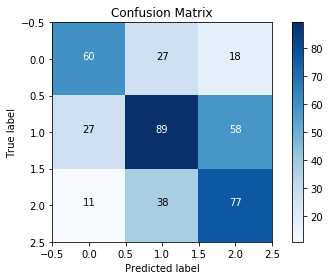

             precision    recall  f1-score   support

    class 0       0.61      0.57      0.59       105
    class 1       0.58      0.51      0.54       174
    class 2       0.50      0.61      0.55       126

avg / total       0.56      0.56      0.56       405

Train Accuracy:  0.9715522572665429 	 Test Accuracy:  0.5580246913580247
Train Precision:  0.9719444118321414 	 Test Precision:  0.5644783165791569
Train Recall:  0.9721080504141053 	 Test Recall:  0.5646779784710819
Train F1 Score:  0.9715601802739428 	 Test F1 Score:  0.5619290859734171

SVM


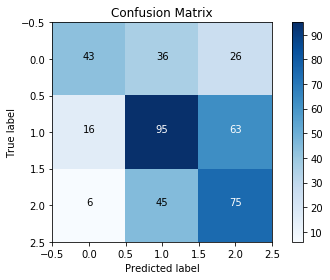

             precision    recall  f1-score   support

    class 0       0.66      0.41      0.51       105
    class 1       0.54      0.55      0.54       174
    class 2       0.46      0.60      0.52       126

avg / total       0.55      0.53      0.53       405

Train Accuracy:  0.7786023500309215 	 Test Accuracy:  0.5259259259259259
Train Precision:  0.7973458810692854 	 Test Precision:  0.5528760873273069
Train Recall:  0.7677525650581848 	 Test Recall:  0.5169129720853859
Train F1 Score:  0.7710541714394932 	 Test F1 Score:  0.5219936250362213

Random Forest


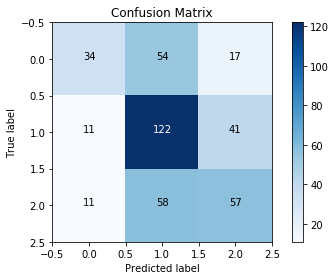

             precision    recall  f1-score   support

    class 0       0.61      0.32      0.42       105
    class 1       0.52      0.70      0.60       174
    class 2       0.50      0.45      0.47       126

avg / total       0.54      0.53      0.51       405

Train Accuracy:  0.9987631416202845 	 Test Accuracy:  0.5259259259259259
Train Precision:  0.9987699876998771 	 Test Precision:  0.541387517474474
Train Recall:  0.9987125787155912 	 Test Recall:  0.49244663382594417
Train F1 Score:  0.9987395003411158 	 Test F1 Score:  0.4978095032588777

Logistical Regression


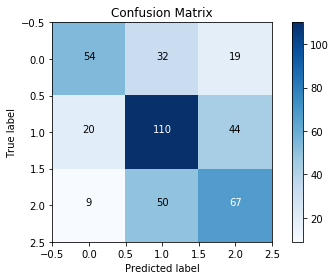

             precision    recall  f1-score   support

    class 0       0.65      0.51      0.57       105
    class 1       0.57      0.63      0.60       174
    class 2       0.52      0.53      0.52       126

avg / total       0.58      0.57      0.57       405

Train Accuracy:  0.8311688311688312 	 Test Accuracy:  0.5703703703703704
Train Precision:  0.8366085680766183 	 Test Precision:  0.579634563896612
Train Recall:  0.8214507080440742 	 Test Recall:  0.5594052180259076
Train F1 Score:  0.8261707829880943 	 Test F1 Score:  0.5663328270937488



In [33]:
Accuracy_val = []
Precision_val = []
Recall_val =[]
F1_score = []
for i in range(0,len(models)):
    print(model_name[i])
    if(i==0):
        clf = models[i]
    else:
        clf = GridSearchCV(models[i],parameters[i],cv=5)
    clf.fit(lyric_train,lyric_train_label)
    lyric_train_label_predict = clf.predict(lyric_train)
    lyric_test_label_predict = clf.predict(lyric_test)
    
    plt.figure
    #Compute Confusion Matrix
    cnf_matrix = confusion_matrix(lyric_test_label, lyric_test_label_predict)
    plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    thresh = cnf_matrix.max() / 2.
    plt.colorbar()
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()
    
    #Classification Report
    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(lyric_test_label, lyric_test_label_predict, target_names=target_names))
    
    #Accuracy, Precision, Recall, F1score
    accuracy_train = accuracy_score(lyric_train_label,lyric_train_label_predict)
    accuracy_test = accuracy_score(lyric_test_label,lyric_test_label_predict)
    print("Train Accuracy: ",accuracy_train,'\t',"Test Accuracy: ",accuracy_test)
    
    precision_train= precision_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    precision_test =  precision_score(lyric_test_label,lyric_test_label_predict,average = 'macro')
    print("Train Precision: ",precision_train,'\t',"Test Precision: ",precision_test)
    
    recall_train= recall_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    recall_test =  recall_score(lyric_test_label,lyric_test_label_predict,average = 'macro')    
    print("Train Recall: ",recall_train,'\t',"Test Recall: ",recall_test) 
    
    f1_train = f1_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    f1_test = f1_score(lyric_test_label,lyric_test_label_predict,average = 'macro')
    print("Train F1 Score: ",f1_train,'\t',"Test F1 Score: ",f1_test)
    
    Accuracy_val.append(accuracy_test)
    Precision_val.append(precision_test)
    Recall_val.append(recall_test)
    F1_score.append(f1_test)
    print()

 
    

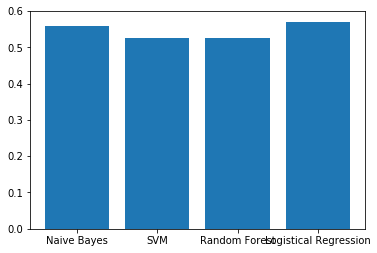

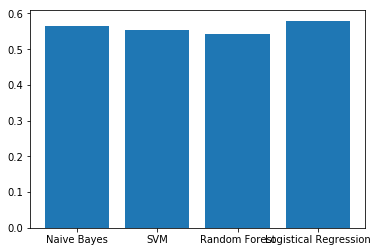

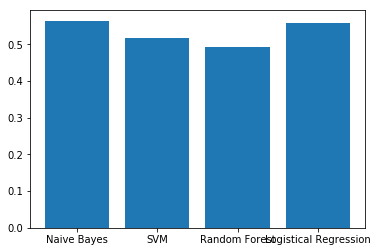

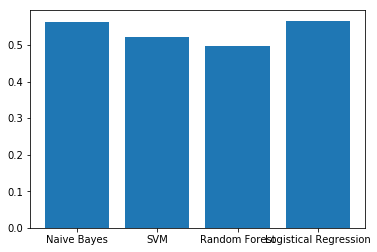

In [34]:
plt.figure
plt.bar(model_name,Accuracy_val)
plt.show()
plt.figure
plt.bar(model_name,Precision_val)
plt.show()
plt.figure
plt.bar(model_name,Recall_val)
plt.show()
plt.figure
plt.bar(model_name,F1_score)
plt.show()

### Convolutional Neural Network

In [ ]:
import keras
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation,Flatten
from keras.layers import Conv1D,MaxPooling1D
from keras import optimizers
from keras.callbacks import LearningRateScheduler


feat_train = lyric_train.astype('float32')
feat_test = lyric_test.astype('float32')
label_train = to_categorical(lyric_train_label,3)
label_test = to_categorical(lyric_test_label,3)
feat_train_shape = feat_train.shape
feat_test_shape = feat_test.shape
print(feat_train_shape,len(feat_train))
print(feat_test_shape)
print(label_train.shape)
print(label_test.shape)

# nb_features = int(feat_train_shape[1]/3)
# # number of features per features type (shape, texture, margin)   
# classes = [0,1,2]
# nb_class = 3


feat_train = feat_train.reshape(feat_train.shape[0],6359,7).astype('float32')
feat_test = feat_test.reshape(feat_test.shape[0],6359,7).astype('float32')

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, input_shape=(6359,7),activation='relu'))
model.add(MaxPooling1D(pool_size=5 ))
model.add(Conv1D(filters =64, kernel_size = 8,padding='valid', activation='relu', use_bias=True))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu',use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(80, activation='relu', use_bias=True))
model.add(Dense(3, activation='softmax'))
learning_rate = 0.05
decay_rate = learning_rate / 100
momentum = 0.8
sgd = optimizers.SGD(lr = learning_rate,momentum = momentum,decay=decay_rate)
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])

history = model.fit(feat_train,label_train,epochs = 30, verbose = 2,validation_data = (feat_test,label_test))
performance = model.evaluate(feat_test,label_test,verbose = 0)
print('Test Loss:', performance[0])
print('Test Accuracy: ', performance[1])
performance = model.evaluate(feat_train,label_train,verbose = 0)
print('Train Loss:', performance[0])
print('Train Accuracy: ', performance[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()